# MoodWeather data Analysis
#### Karolina Jankiewicz - January 2019

### Basic time series data analysis

In [1]:
# Importing libraries

import os
import warnings
warnings.filterwarnings('ignore')
## General packages for working with vectors, datasets, and visualization
import numpy as np
from numpy.random import normal, seed
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # This is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

## Packages for analyzing time series
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
## The path where we have datasets
print(os.listdir("./data"))

['2019-01-07_tweets.csv', '2019-01-07_weather.csv', 'tweets.csv', 'weather.csv']


In [114]:
#Import main data files
weather = pd.read_csv(
    './data/weather.csv',
    index_col='time',infer_datetime_format=True,
    parse_dates=['time'] )

weather

tweets = pd.read_csv(
    './data/tweets.csv',
    index_col='time',infer_datetime_format=True,
    parse_dates=['time'] )
tweets

,GB_Pos,GB_Neg,GB_Neu,GB_Total,US_Pos,US_Neg,US_Neu,US_Total,JP_Pos,JP_Neg,JP_Neu,JP_Total
time,,,,,,,,,,,,
2018-12-27 20:45:43.149,2,0,1,3,2,0,1,3,0,0,3,3
2018-12-27 20:45:48.447,2,0,2,4,0,1,4,5,0,0,1,1
2018-12-27 20:45:53.823,1,0,2,3,2,1,7,10,0,0,2,2
2018-12-27 20:45:59.153,0,0,2,2,3,0,2,5,0,0,1,1
2018-12-27 20:46:04.791,1,0,0,1,2,2,4,8,0,0,0,0
2018-12-27 20:46:10.299,2,0,0,2,1,0,4,5,0,0,0,0
2018-12-27 20:46:16.693,1,0,2,3,2,0,2,4,0,0,0,0
2018-12-27 20:46:21.778,1,0,1,2,2,0,6,8,0,0,2,2
2018-12-27 20:46:27.341,0,1,1,2,3,1,4,8,0,0,2,2


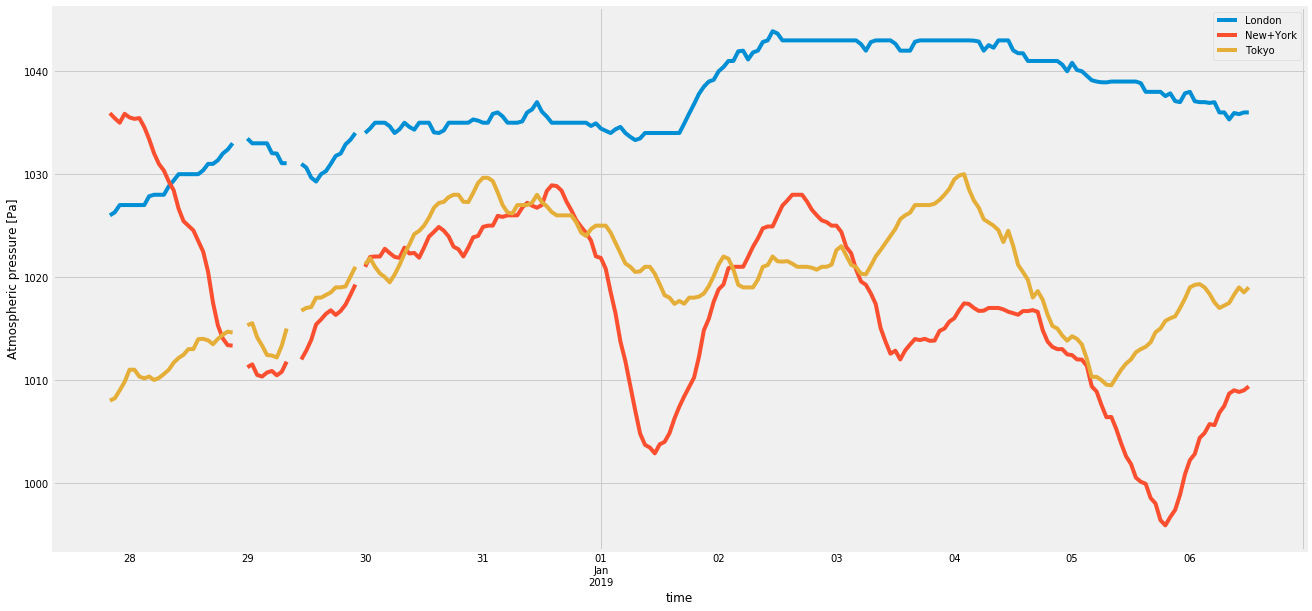

KeyError: 'Column not found: 0'

In [140]:
#Plot pressure data

plt.figure(figsize=(20, 10))
grouped=weather.groupby('city')
shifts={'London':-1, 'New+York':-6, 'Tokyo':8} #Shift all to the same timezone (initial is GMT+1)

for name, data in grouped:
    timeshift=shifts[name]
    pres_dat=data['pressure'].shift(timeshift)
    pres_dat=pres_dat.resample('H').mean()
    pres_dat.plot(label =name) 
plt.ylabel('Atmospheric pressure [Pa]')
plt.legend()
plt.show()

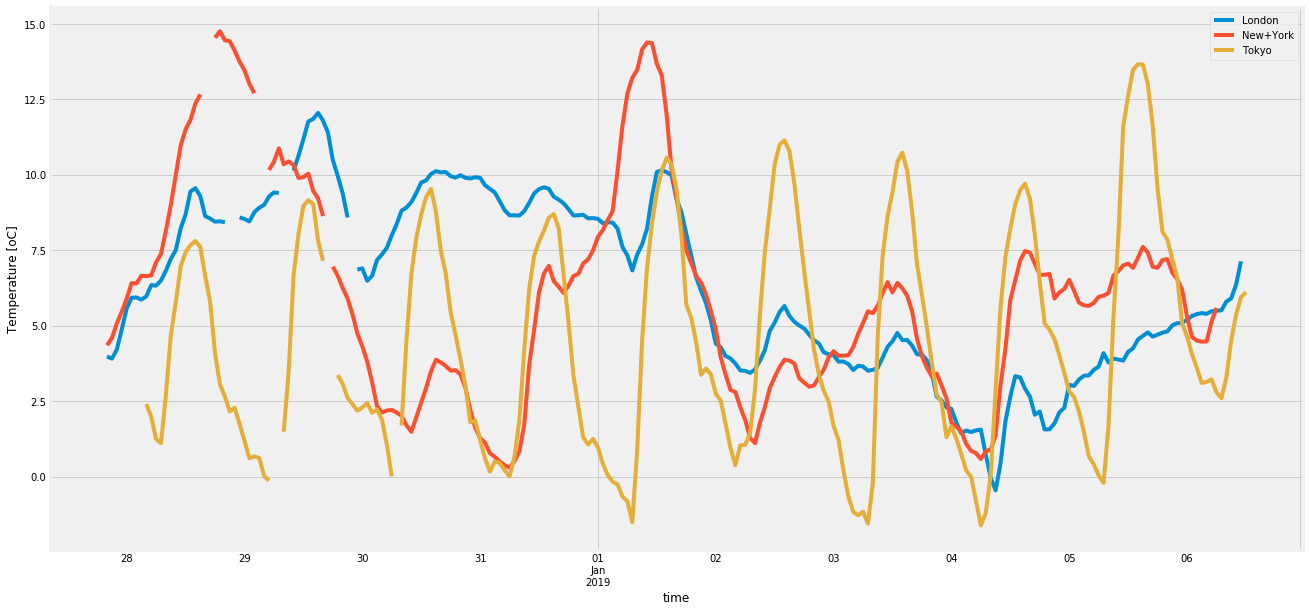

In [116]:
#Plot temperature

plt.figure(figsize=(20, 10))
for name, data in grouped:
    timeshift=shifts[name]
    temp_dat=data['temperature']-273#.interpolate(method='cubic')#convert to celsius
    temp_dat=temp_dat.resample('H').mean()
    temp_dat.shift(timeshift).plot(label =name) 
plt.ylabel('Temperature [oC]')
plt.legend()
plt.show()

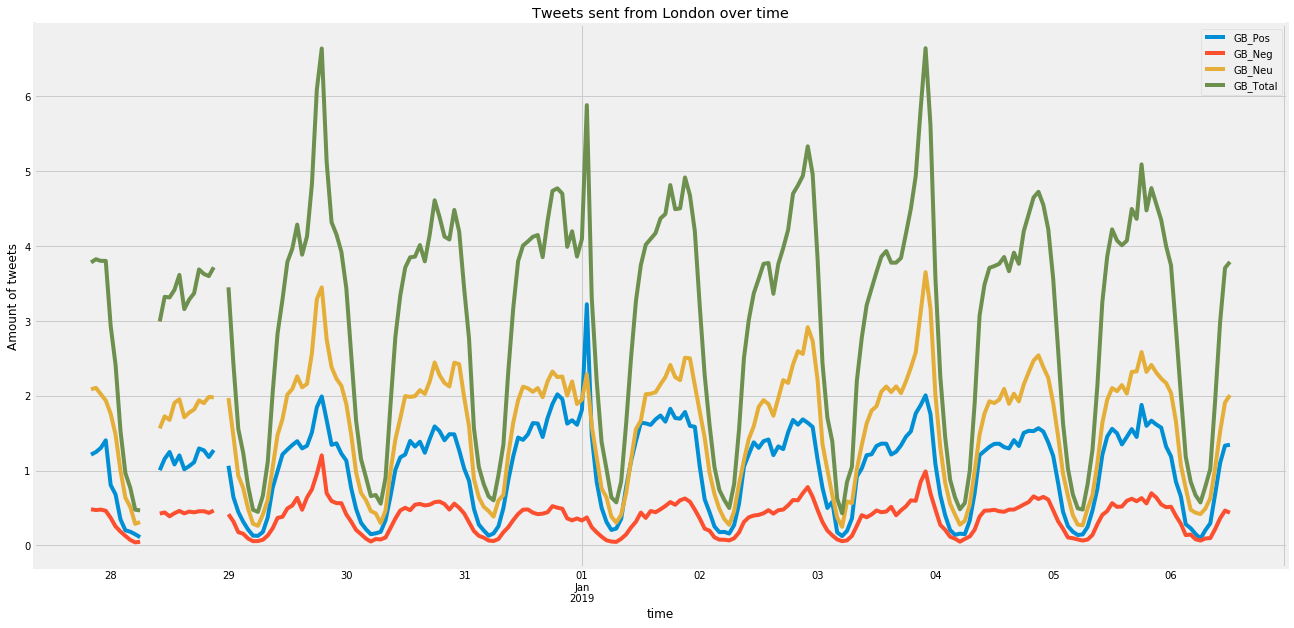

In [109]:
plt.figure(figsize=(20, 10))
freq='H'
gb_pos=tweets['GB_Pos'].resample(freq).mean()
gb_neg=tweets['GB_Neg'].resample(freq).mean()
gb_neu=tweets['GB_Neu'].resample(freq).mean()
gb_tot=tweets['GB_Total'].resample(freq).mean()

gb_p=gb_pos#/gb_tot
gb_n=gb_neg#/gb_tot
gb_nt=gb_neu#/gb_tot

gb_p.plot()
gb_n.plot()
gb_nt.plot()
gb_tot.plot()

plt.ylabel('Amount of tweets')
plt.title('Tweets sent from London over time')
plt.legend()
plt.show()

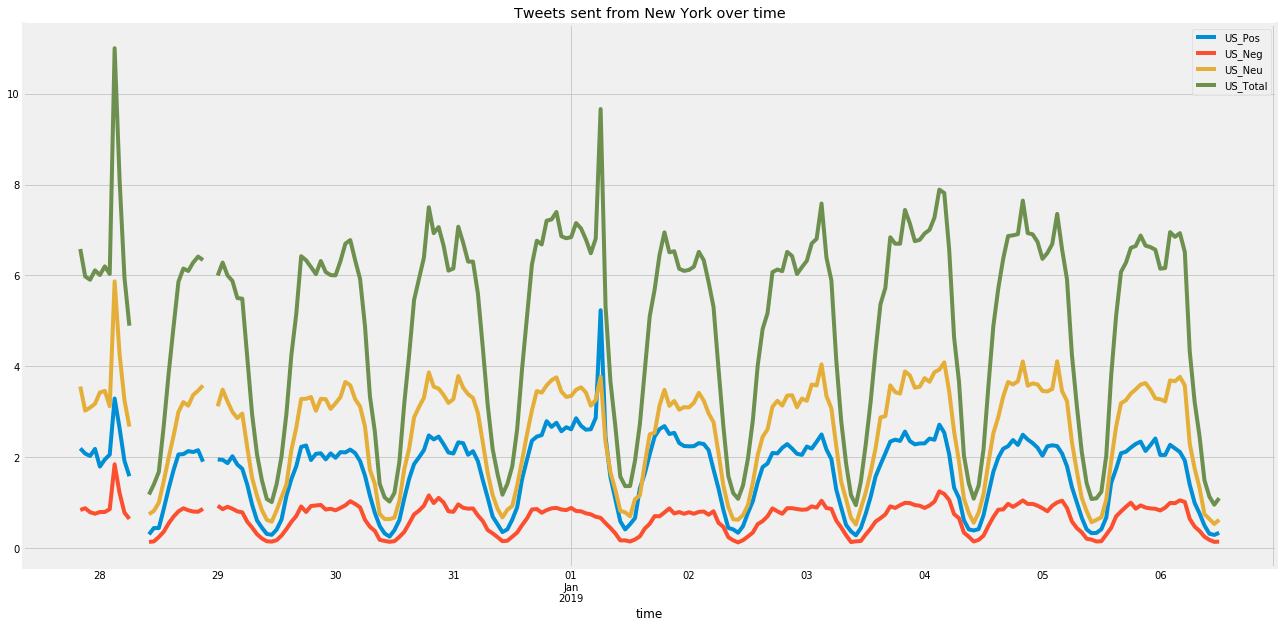

In [111]:
plt.figure(figsize=(20, 10))
freq='H'
us_pos=tweets['US_Pos'].resample(freq).mean()
us_neg=tweets['US_Neg'].resample(freq).mean()
us_neu=tweets['US_Neu'].resample(freq).mean()
us_tot=tweets['US_Total'].resample(freq).mean()

us_p=us_pos#/us_tot
us_n=us_neg#/us_tot
us_nt=us_neu#/us_tot

us_p.plot()
us_n.plot()
us_nt.plot()
us_tot.plot()

plt.title('Tweets sent from New York over time')
plt.legend()
plt.show()

# Investigating autocorrelations

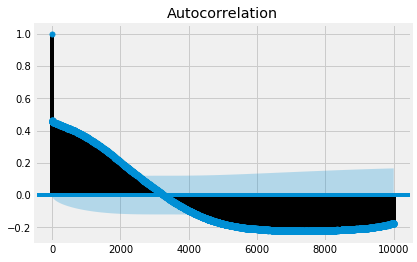

In [156]:
# Autocorrelation of tweets from New York
acf = plot_acf(tweets['US_Total'], lags=10000)
plt.show()

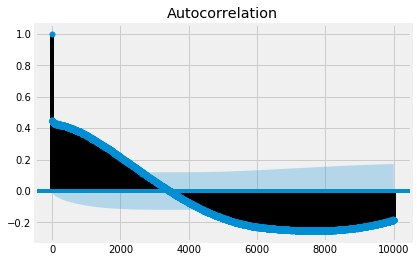

In [157]:
# Autocorrelation of tweets from London
acf = plot_acf(tweets['GB_Total'], lags=10000)
plt.show()

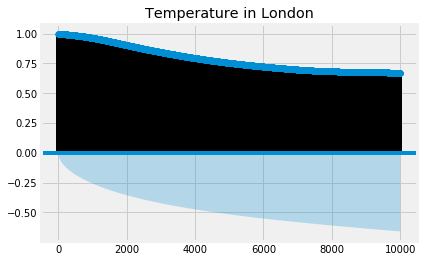

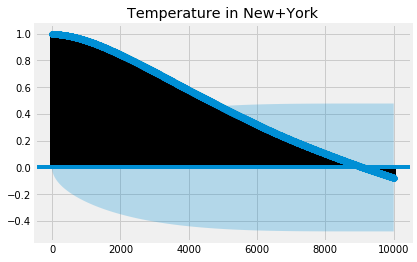

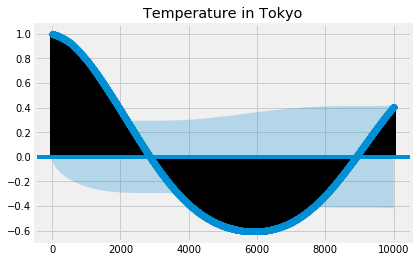

In [161]:
# Autocorrelation of temperature in the three cities
for name, data in grouped:
    acf = plot_acf(data['temperature'], lags=10000)
    plt.title('Temperature in '+name)
    plt.show()

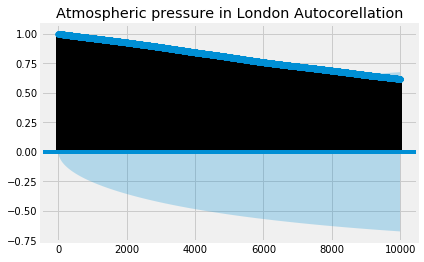

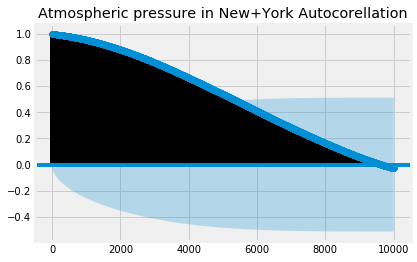

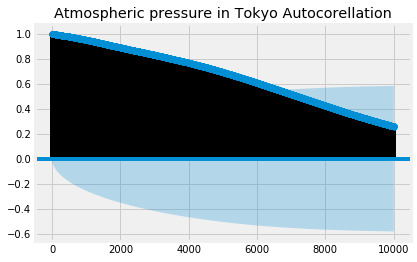

In [162]:
# Autocorrelation of pressure in the three cities
for name, data in grouped:
    acf = plot_acf(data['pressure'], lags=10000)
    plt.title('Atmospheric pressure in '+name+' Autocorellation')
    plt.show()

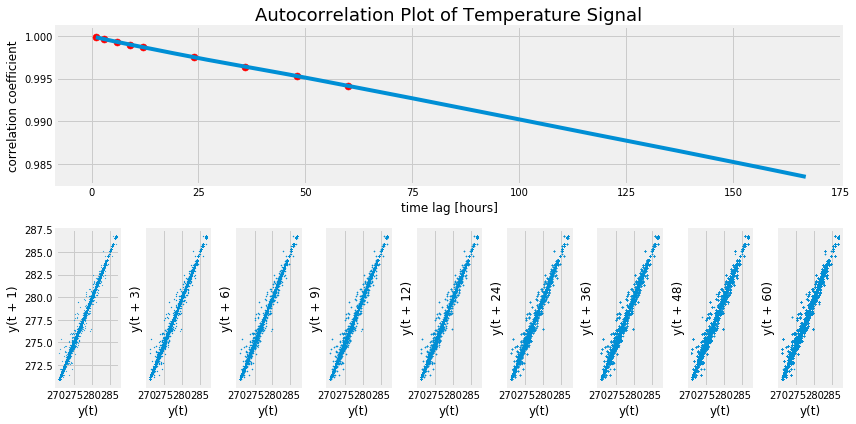

In [165]:
#%% show autocorr and lag plots
import matplotlib.gridspec as gridspec
from pandas.plotting import autocorrelation_plot, lag_plot

selectedLagPoints = [1,3,6,9,12,24,36,48,60]
maxLagDays = 7

for name, data in grouped:
    originalSignal = data['temperature']

# set grid spec of the subplots
plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, len(selectedLagPoints))
axTopRow = plt.subplot(gs[0, :])
axBottomRow = []
for i in range(len(selectedLagPoints)):
    axBottomRow.append(plt.subplot(gs[1, i]))

# plot autocorr
allTimeLags = np.arange(1,maxLagDays*24)
autoCorr = [originalSignal.autocorr(lag=dt) for dt in allTimeLags]
axTopRow.plot(allTimeLags,autoCorr); 
axTopRow.set_title('Autocorrelation Plot of Temperature Signal', fontsize=18);
axTopRow.set_xlabel('time lag [hours]'); axTopRow.set_ylabel('correlation coefficient')
selectedAutoCorr = [originalSignal.autocorr(lag=dt) for dt in selectedLagPoints]
axTopRow.scatter(x=selectedLagPoints, y=selectedAutoCorr, s=50, c='r')

# plot scatter plot of selected points
for i in range(len(selectedLagPoints)):
    lag_plot(originalSignal, lag=selectedLagPoints[i], s=0.5, alpha=0.7, ax=axBottomRow[i])    
    if i >= 1:
        axBottomRow[i].set_yticks([],[])
plt.tight_layout()

TypeError: 'AxesSubplot' object does not support indexing

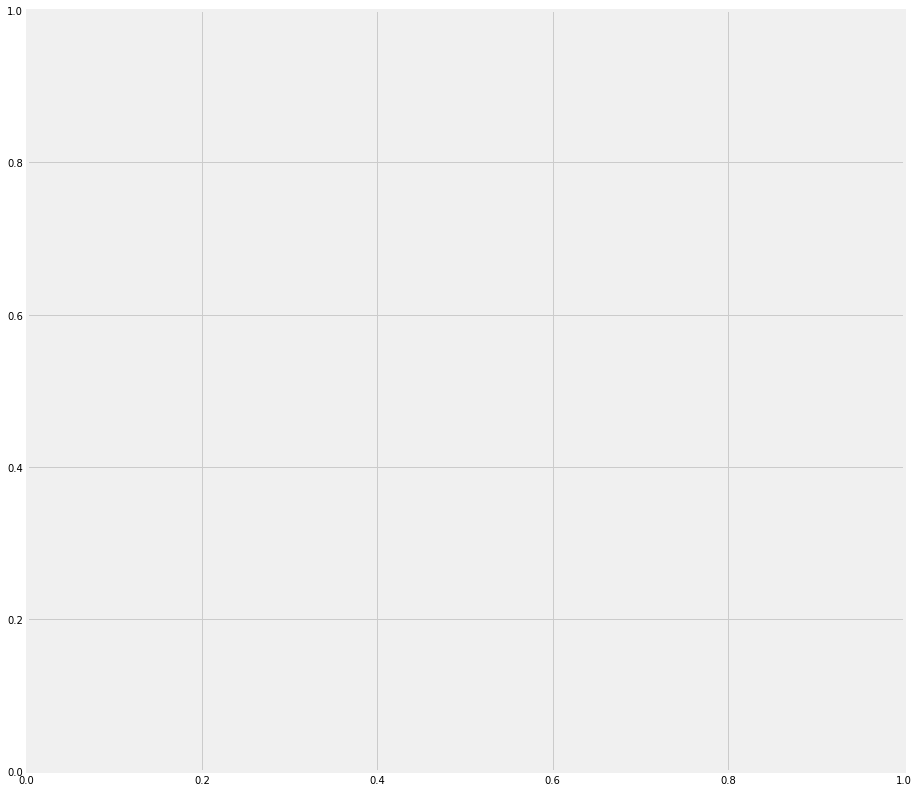

In [169]:
#%% zoom in and out on the autocorr plot
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,14))

timeLags = np.arange(1,20*24)
autoCorr = [originalSignal.autocorr(lag=dt) for dt in timeLags]
ax[0].plot(1.0/(24)*timeLags, autoCorr); ax[0].set_title('Autocorrelation Plot', fontsize=20);
ax[0].set_xlabel('time lag [hours]'); ax[0].set_ylabel('correlation coeff', fontsize=12);
